In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ahabi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ahabi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ahabi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(tokens)

In [4]:
df = pd.read_csv('sentiment_dataset.csv')
print(f"Dataset loaded with {len(df)} samples")
print(f"\nSentiment distribution:\n{df['sentiment'].value_counts()}")
df.head(10)

Dataset loaded with 3000 samples

Sentiment distribution:
sentiment
neutral     1000
positive    1000
negative    1000
Name: count, dtype: int64


,text,sentiment
0,Mediocre laptop. You get what you pay for.,neutral
1,This phone is okay. Does the job.,neutral
2,Fantastic order. Will definitely recommend to ...,positive
3,Fantastic movie. Will definitely recommend to ...,positive
4,This order made my day! I'm really satisfied.,positive
5,Mediocre order. You get what you pay for.,neutral
6,"It's a decent experience, works as intended.",neutral
7,Poor quality application and horrible customer...,negative
8,Poor quality tool and horrible customer support.,negative
9,Fantastic device. Will definitely recommend to...,positive


In [5]:
df['processed_text'] = df['text'].apply(preprocess_text)

X = df['processed_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Feature matrix shape: {X_train_tfidf.shape}")

Feature matrix shape: (2400, 622)


In [7]:
models = {
    'Naive Bayes': MultinomialNB(alpha=1.0),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

best_model = None
best_accuracy = 0
model_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    
    model_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'predictions': y_pred
    }
    
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = name


Training Naive Bayes...
Naive Bayes Accuracy: 1.0000
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       200
     neutral       1.00      1.00      1.00       200
    positive       1.00      1.00      1.00       200

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600


Training Logistic Regression...
Logistic Regression Accuracy: 1.0000
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       200
     neutral       1.00      1.00      1.00       200
    positive       1.00      1.00      1.00       200

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600


Training Random Forest...
Random Forest Accuracy: 1.0000
              precision    recall  f1-score   support

 

In [8]:
print(f"\nBest model: {best_model_name} with accuracy: {best_accuracy:.4f}")
joblib.dump(best_model, 'models/sentiment_model.pkl')
joblib.dump(vectorizer, 'models/tfidf_vectorizer.pkl')


Best model: Naive Bayes with accuracy: 1.0000


['models/tfidf_vectorizer.pkl']

In [9]:
def predict_sentiment(text):
    processed_text = preprocess_text(text)
    text_tfidf = vectorizer.transform([processed_text])
    prediction = best_model.predict(text_tfidf)[0]
    probabilities = best_model.predict_proba(text_tfidf)[0]
    confidence = max(probabilities)
    return prediction, confidence

In [10]:
test_cases = [
    "This product is absolutely amazing! I love it!",
    "Terrible quality. I hate this product.",
    "It's okay, nothing special but does the job.",
    "Best purchase ever! Highly recommend!",
    "Worst experience of my life. Avoid at all costs!",
    "The product is decent for its price range."
]

for text in test_cases:
    sentiment, confidence = predict_sentiment(text)
    print(f"Text: '{text}'")
    print(f"Predicted: {sentiment} (confidence: {confidence:.3f})")
    print("-" * 50)

Text: 'This product is absolutely amazing! I love it!'
Predicted: positive (confidence: 0.970)
--------------------------------------------------
Text: 'Terrible quality. I hate this product.'
Predicted: negative (confidence: 0.976)
--------------------------------------------------
Text: 'It's okay, nothing special but does the job.'
Predicted: neutral (confidence: 0.998)
--------------------------------------------------
Text: 'Best purchase ever! Highly recommend!'
Predicted: negative (confidence: 0.477)
--------------------------------------------------
Text: 'Worst experience of my life. Avoid at all costs!'
Predicted: negative (confidence: 0.832)
--------------------------------------------------
Text: 'The product is decent for its price range.'
Predicted: neutral (confidence: 0.893)
--------------------------------------------------


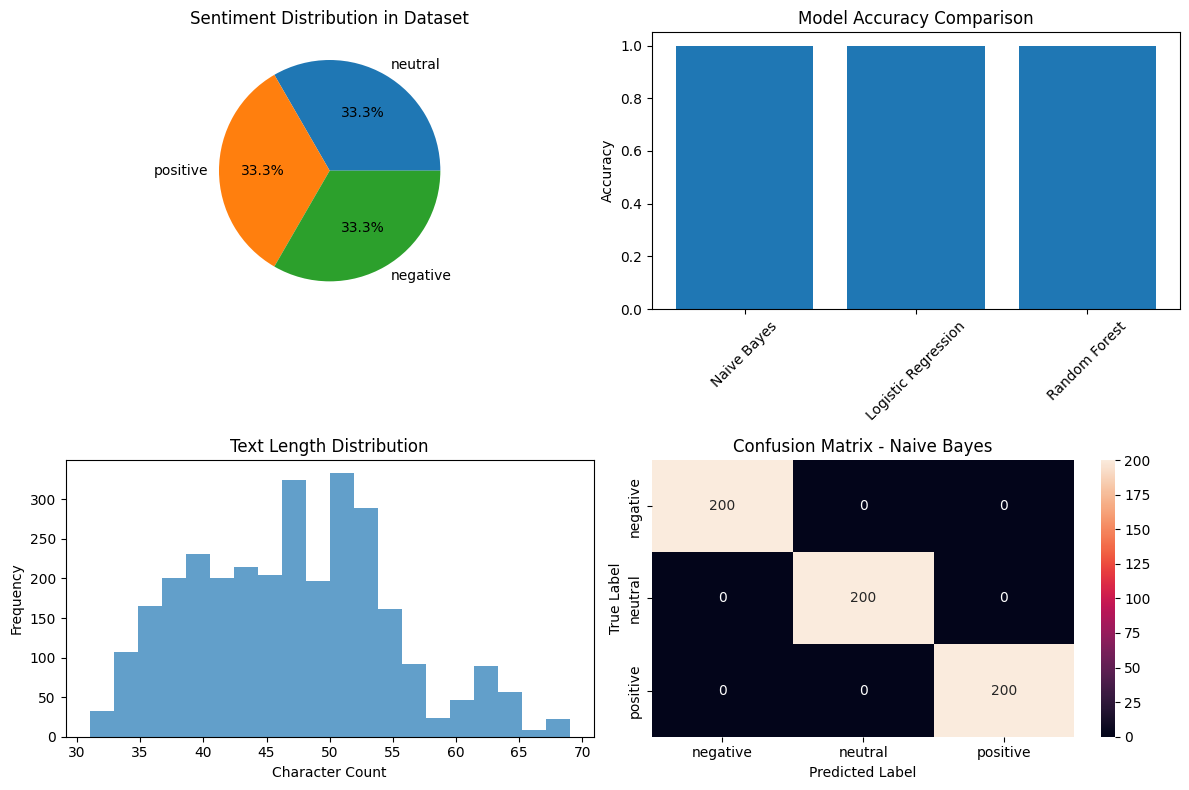

In [11]:
plt.figure(figsize=(12, 8))

# Pie Chart
plt.subplot(2, 2, 1)
sentiment_counts = df['sentiment'].value_counts()
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution in Dataset')

# Bar Chart
plt.subplot(2, 2, 2)
model_names = list(model_results.keys())
accuracies = [model_results[name]['accuracy'] for name in model_names]
plt.bar(model_names, accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# Histogram
plt.subplot(2, 2, 3)
text_lengths = df['text'].str.len()
plt.hist(text_lengths, bins=20, alpha=0.7)
plt.title('Text Length Distribution')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

# Confusion Matrix
plt.subplot(2, 2, 4)
cm = confusion_matrix(y_test, model_results[best_model_name]['predictions'])
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('sentiment_analysis_results.png', dpi=300, bbox_inches='tight')
plt.show()